## Audio Signal Processing using python

mathematical concept about audio processing in any audio system and implement the mathematics in python.

In [2]:
import numpy as np
from scipy.io import wavfile
from scipy.fftpack import dct
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

The raw signal has the following from in the time domain: 


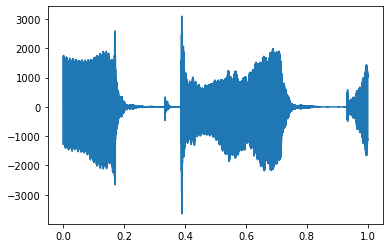

In [4]:
sample_rate, signal = wavfile.read('../dataset/gas_alarm_1.wav')

signal = signal[0:int(10* sample_rate)]
Time = np.linspace(0, len(signal) / sample_rate, num=len(signal))

print('The raw signal has the following from in the time domain: ')
plt.plot(Time, signal)

## Pre-Emphasis

The first step is to apply a pre-emphesis filter on signal to amplify the high frequencies. A pre-emphesis filter is useful in several ways: - balance frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies - avoid numerical problems during fourier operation - Might also improve the signal to Noise Ratio (SNR)

The pre-emphesis filter can be applied to a signal x using the first order filter in the following equation:

y(t)=x(t)−αx(t−1)

which can be easily implemented using the following line, where typical values for the filter coefficeint ( α
) are 0.95 to 0.97, pre_empasis = 0.97

In [5]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

Pre-emphasis has a modest effect in modern systems, mainly because most of the motivations for the pre-emphasis filter can be achieved using mean normalization except for avoiding the Fourier transfrom numerical issues which should not be a problem in modern FFT implementations.

The signal after pre-emphasis has the following effect in orignal signal.

## Framing

After pre-emphasis, we need to split the signal into short-time frames. The rationale behind this step is that frequencies in a signal change over time, so in most cases it dosen't make sense to do the Fourier Transform across the entier signal in that we would lose the frequency contours of the signal over time. To avoid that, we can safely assume that frequencies in a signal are stationary over a very short period of time. Therefore, by doing a Fourier transform over this short-time frame, we can obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames.

Typical frame sizes in speech processing rnage from 20 ms to 40 ms with 50% (+/- 10%) overlap between conseutive frames.Popular settings are 25 ms for the frame size, frame_size = 0.025 and a 10 ms stride (15 ms overlap), frame_stride = 0.01

In [6]:
frame_size = 0.02
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]


## Window

After slicing the signal into frames, we apply a window function such as the Hamming window to each frame. A Hamming window has the following form:

![eq1](pic/rumus1.PNG)

where, 
0 ≤ n ≤ N-1,
N is the window length.

There are several reasons why we need to apply a window function to the frames, notably to counteract the assumption made by the FFT that the data is infinite and to reduce spectral leakage.

In [9]:
frames *= np.hanning(frame_length)
# frames *= 0.54 - 0.46 * np.cos((2 * np.pi * n) / (frame_length - 1))  # Explicit Implementation **

## Fourier-Transfrom and Power Spectrum

We can now do an N-point FFT on each frame to calculate the frequency spectrum, which is also called Short-Time-Fourier-Transfrom (STFT), where N is typically 256 or 512, NFFT = 512; and then compute the power spectrum (Periodogram) using the following equation: 

![eq2](pic/rumus2.PNG)

where , x<sub>i</sub> is the i<sup>th</sup> frame of signal x. This can be easily imlemented with the following lines:

In [10]:
NFFT = 256

mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum


## Filter Banks

The final step to computing filter banks is applying triangular filters, typically 40 filters, nfilt = 40 on a Mel-scale to the power spectrum to extract frequency bands. The Mel-Scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequenceis and less discriminative at higher frequencies. We can convert between Hertz (f) and Mel ( m) using the following equations: 

![eq1](pic/rumus3.PNG)

Each filter in the filter bank is triangular having a response of 1 at the center frequency and decrease linearly towards 0 till it reaches the center frequencies of the two adjacent filters where the response is 0. which can be modeled by the following equation:

![eq1](pic/rumus4.PNG)

In [11]:
nfilt = 40

low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB


After applying the filter bank to the power spectrum (peridogram) of the signal, we obtain the following spectrogram:

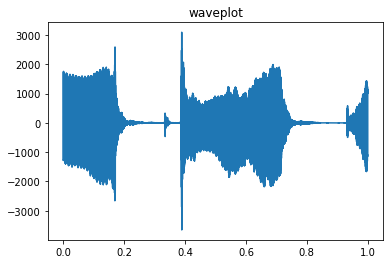

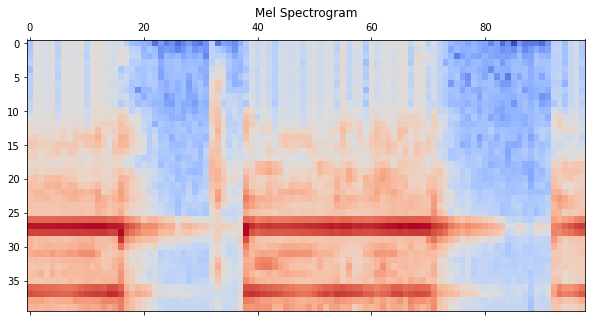

In [13]:
#plt.rcParams["figure.figsize"] = (10,5)
plt.title("waveplot")
plt.plot(Time, signal)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
cax = ax.matshow(
    np.transpose(filter_banks),
    interpolation="nearest",
    aspect="auto",
    cmap=plt.cm.coolwarm,
    origin="lower",
)
#fig.colorbar(cax)
plt.title("Mel Spectrogram")
plt.show()


## Mel-frequency cepstral Coecfficents (MFCCs)

It turns out that filter bank coefficients computed in the previous step are higly correlated, which could be problematic in some machine learning algorithms. Therefore, we can apply Discrete Cosine Transform(DCT) to decorrelate the filter bank coefficients and yield compressed representation of filter banks. Typically, for Automatic SPeech Recognition (ASR), the resulting cepstral coefficeints 2- 13 are retained and the rest are discareded; num_ceps = 12. The reasons for discarding the other coefficeints is that they represent fast changes in the filter bank coefficients and these fine details don't contribute to ASR.

In [14]:
num_ceps = 13
mfcc = dct(filter_banks, type = 2, axis=1, norm="ortho")[:,1: (num_ceps + 1)] # keep 2-13

One may apply sinusoidal liftering to the MFCCs to de-emphasize higher MFCCs which has been claimed to improve speech recognition in noisy signals.

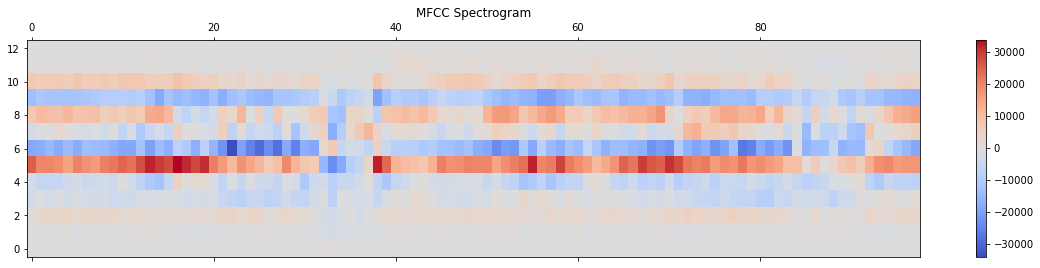

In [17]:
cep_lifter = 13
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n/ cep_lifter)
mfcc *= lift

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
cax = ax.matshow(
    np.transpose(mfcc),
    interpolation="nearest",
    aspect="auto",
    cmap=plt.cm.coolwarm,
    origin="lower",
)
fig.colorbar(cax)
plt.title("MFCC Spectrogram")
plt.show()


## Mean Normalization

As previously mentioned, to balance the spectrum and improve the Signal-to-Noise (SNR), we can simply substract the mean of each coefficeint from all frames,

filter_banks -= (np.mean(filter_banks, axis = 0) + 1e-8)

and similarly for MFCCs:

mfcc -= (np.mean(mfcc, axis = 0) + 1e-8)

To this point, the steps to compute filter banks and MFCCs were discussed in terms of their motivation and implementations.It is interesting to note that all steps needed to compute filter banks were motivated by the nature of the speech signal and the human perception of such signals.

On the Contrary, the extra steps needed to compute MFCCs were motivated by the limitation of some classifical machine learning algorithms.The Discrete cosine Transfrom (DCT) was needed to decorrelate filter banks coeffiicients, a process refer as whitening. In particular, MFCCs were very popular with Gaussian Mixture Models - Hidden Markov Models(GMM - HMM). But with the advent of Deep learning in speech system, one might not need DCT.

In [18]:
filter_banks -= (np.mean(filter_banks, axis = 0) + 1e-8)
mfcc -= (np.mean(mfcc, axis = 0) + 1e-8)


In [19]:
filter_banks.shape

(98, 40)